In [ ]:
# Core Libraries
import numpy as np
import pandas as pd

# Text Processing
import nltk
from nltk.stem import WordNetLemmatizer
# Check if "wordnet" is available before downloading
try:
    from nltk.corpus import wordnet
except:
    nltk.download("wordnet")
    from nltk.corpus import wordnet

# Machine Learning Models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB

# Model Evaluation and Tuning
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score


# Model Saving
import joblib

# Visualization
import matplotlib.pyplot as plt

# Custom functions & vars
from functions import pull_redcap_report, get_age_at_post
from functions import clean_text, tokenize_and_remove_stopwords, get_cluster_features, preprocess_features
from constants import participants_token, posts_token, participants_table1, train_test_data

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jeannepowell/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
posts = pull_redcap_report(posts_token, train_test_data)
participants = pull_redcap_report(participants_token, participants_table1)
posts = get_age_at_post(posts, participants)

In [ ]:


lemmatizer = WordNetLemmatizer()

posts['clean_text'] = posts['text'].apply(clean_text)
posts['tokenized_text'] = posts['clean_text'].apply(tokenize_and_remove_stopwords)
posts['lemma'] = posts['tokenized_text'].apply(lambda text: " ".join([lemmatizer.lemmatize(word) for word in text.split()]))


posts["text_cluster"] = posts['clean_text'].apply(get_cluster_features)

# Split data
train_data = posts[posts['train_test_split'] == 1]
test_data = posts[posts['train_test_split'] == 2]

# Prepare data for training
X_train, X_test, y_train, y_test = preprocess_features(train_data, test_data)

Vectorizers saved.
Scaler saved.
Encoder saved.


In [4]:
# Run experiment
from functions import train_and_evaluate_model
# Create a DataFrame to store predictions
test_predictions = pd.DataFrame({'record_id': test_data['record_id']})

In [5]:
# Train and save models, saving their predictions
knn_model = KNeighborsClassifier()
knn_param_grid = {
    'n_neighbors': range(5, 51),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}
best_knn = train_and_evaluate_model(knn_model, knn_param_grid, X_train, y_train, X_test, y_test, "KNN", test_predictions)

Training KNN...
Finished training KNN in 233.54 seconds.

Best hyperparameters for KNN: {'metric': 'euclidean', 'n_neighbors': 8, 'weights': 'uniform'}

Confusion Matrix:
[[790  49]
 [204 307]]

Classification Report:
              precision    recall  f1-score   support

           0     0.7948    0.9416    0.8620       839
           1     0.8624    0.6008    0.7082       511

    accuracy                         0.8126      1350
   macro avg     0.8286    0.7712    0.7851      1350
weighted avg     0.8204    0.8126    0.8038      1350

Saved KNN to KNN_best_model.joblib.



In [6]:
# SVM
svm = SVC(probability=True)
svm_param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'gamma': ['scale', 'auto']
}
best_svm = train_and_evaluate_model(svm, svm_param_grid, X_train, y_train, X_test, y_test, "SVM", test_predictions)



Training SVM...
Finished training SVM in 1116.57 seconds.

Best hyperparameters for SVM: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}

Confusion Matrix:
[[775  64]
 [127 384]]

Classification Report:
              precision    recall  f1-score   support

           0     0.8592    0.9237    0.8903       839
           1     0.8571    0.7515    0.8008       511

    accuracy                         0.8585      1350
   macro avg     0.8582    0.8376    0.8456      1350
weighted avg     0.8584    0.8585    0.8564      1350

Saved SVM to SVM_best_model.joblib.



In [7]:
# Random Forest
rf = RandomForestClassifier(random_state=42)
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}
best_rf = train_and_evaluate_model(rf, rf_param_grid, X_train, y_train, X_test, y_test, "RandomForest", test_predictions)


Training RandomForest...
Finished training RandomForest in 385.28 seconds.

Best hyperparameters for RandomForest: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}

Confusion Matrix:
[[820  19]
 [204 307]]

Classification Report:
              precision    recall  f1-score   support

           0     0.8008    0.9774    0.8803       839
           1     0.9417    0.6008    0.7336       511

    accuracy                         0.8348      1350
   macro avg     0.8712    0.7891    0.8069      1350
weighted avg     0.8541    0.8348    0.8248      1350

Saved RandomForest to RandomForest_best_model.joblib.



In [8]:
# AdaBoost

# Define the AdaBoost classifier
ada = AdaBoostClassifier(random_state=42, algorithm='SAMME')

# Hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1, 10],
}

# Train and evaluate AdaBoost
best_ada = train_and_evaluate_model(ada, param_grid, X_train, y_train, X_test, y_test, "AdaBoost", test_predictions)


Training AdaBoost...
Finished training AdaBoost in 109.61 seconds.

Best hyperparameters for AdaBoost: {'learning_rate': 1, 'n_estimators': 100}

Confusion Matrix:
[[830   9]
 [284 227]]

Classification Report:
              precision    recall  f1-score   support

           0     0.7451    0.9893    0.8500       839
           1     0.9619    0.4442    0.6078       511

    accuracy                         0.7830      1350
   macro avg     0.8535    0.7167    0.7289      1350
weighted avg     0.8271    0.7830    0.7583      1350

Saved AdaBoost to AdaBoost_best_model.joblib.



In [9]:
# Naive Bayes
nb = MultinomialNB()
nb_param_grid = {
    'alpha': [0.1, 0.5, 1, 5, 10]
}

best_nb = train_and_evaluate_model(nb, nb_param_grid, X_train, y_train, X_test, y_test,"NaiveBayes", test_predictions)

Training NaiveBayes...
Finished training NaiveBayes in 0.22 seconds.

Best hyperparameters for NaiveBayes: {'alpha': 0.1}

Confusion Matrix:
[[798  41]
 [121 390]]

Classification Report:
              precision    recall  f1-score   support

           0     0.8683    0.9511    0.9078       839
           1     0.9049    0.7632    0.8280       511

    accuracy                         0.8800      1350
   macro avg     0.8866    0.8572    0.8679      1350
weighted avg     0.8822    0.8800    0.8776      1350

Saved NaiveBayes to NaiveBayes_best_model.joblib.



In [10]:
# Decision Tree
dt = DecisionTreeClassifier(random_state=42)
dt_param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
best_dt = train_and_evaluate_model(dt, dt_param_grid, X_train, y_train, X_test, y_test, "DecisionTree", test_predictions)

Training DecisionTree...
Finished training DecisionTree in 54.59 seconds.

Best hyperparameters for DecisionTree: {'criterion': 'gini', 'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 2}

Confusion Matrix:
[[765  74]
 [154 357]]

Classification Report:
              precision    recall  f1-score   support

           0     0.8324    0.9118    0.8703       839
           1     0.8283    0.6986    0.7580       511

    accuracy                         0.8311      1350
   macro avg     0.8304    0.8052    0.8141      1350
weighted avg     0.8309    0.8311    0.8278      1350

Saved DecisionTree to DecisionTree_best_model.joblib.



In [11]:
# XGBoost

xgb = XGBClassifier(eval_metric='logloss', random_state=42)
xgb_param_grid = {
    'n_estimators': [50, 100],  # Reduce number of trees
    'max_depth': [3, 5],  # Reduce depth (smaller trees)
    'learning_rate': [0.01, 0.1],
    'tree_method': ['hist'],  # Optimize for CPU
    'subsample': [0.8],  # Use only 80% of the data per tree
    'colsample_bytree': [0.8]  # Use only 80% of features per tree
}

best_xgb = train_and_evaluate_model(xgb, xgb_param_grid, X_train, y_train, X_test, y_test, "XGBoost", test_predictions)

Training XGBoost...
Finished training XGBoost in 34.50 seconds.

Best hyperparameters for XGBoost: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8, 'tree_method': 'hist'}

Confusion Matrix:
[[819  20]
 [204 307]]

Classification Report:
              precision    recall  f1-score   support

           0     0.8006    0.9762    0.8797       839
           1     0.9388    0.6008    0.7327       511

    accuracy                         0.8341      1350
   macro avg     0.8697    0.7885    0.8062      1350
weighted avg     0.8529    0.8341    0.8241      1350

Saved XGBoost to XGBoost_best_model.joblib.



In [12]:
# Ensemble predictions (optional, if applicable)

ensemble = VotingClassifier(
    estimators=[
        ('knn', best_knn),
        ('svm', best_svm),
        ('rf', best_rf),
        ('ada', best_ada),
        ('nb', best_nb),
        ('dt', best_dt),
        ('xgb', best_xgb)
    ],
    voting='soft'
)
ensemble.fit(X_train, y_train)
test_predictions['ensemble_test_pred'] = ensemble.predict(X_test)

# Save the trained ensemble model
joblib.dump(ensemble, 'ensemble.joblib')

['ensemble.joblib']

In [ ]:
# Generate predictions on the test set
y_pred_ensemble = ensemble.predict(X_test)

# Print confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_ensemble))

# Print classification report (precision, recall, F1-score)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_ensemble, digits=4))

Confusion Matrix:
[[820  19]
 [149 362]]

Classification Report:
              precision    recall  f1-score   support

           0     0.8462    0.9774    0.9071       839
           1     0.9501    0.7084    0.8117       511

    accuracy                         0.8756      1350
   macro avg     0.8982    0.8429    0.8594      1350
weighted avg     0.8856    0.8756    0.8710      1350



In [ ]:
import_df = test_predictions
import_df = import_df.rename(columns={
    'randomforest_test_pred': 'rf_test_pred',
    'naivebayes_test_pred': 'naive_bayes_test_pred',
    'decisiontree_test_pred': 'dt_test_pred'
})

from functions import redcap_upload
response = redcap_upload(import_df)

,record_id,knn_test_pred,svm_test_pred,rf_test_pred,adaboost_test_pred,naive_bayes_test_pred,dt_test_pred,xgboost_test_pred,ensemble_test_pred
1,79,0,0,0,0,0,0,0,0
5,98,0,0,0,0,0,0,0,0
7,142,0,0,0,0,0,0,0,0
8,176,0,0,0,0,0,0,0,0
9,197,0,1,0,0,0,0,0,0


In [ ]:
def evaluate(preds, labels, metric, average=None):
    """Calculate a performance metric."""
    if metric == 'accuracy':
        return accuracy_score(labels, preds)
    elif metric == 'f1':
        return f1_score(labels, preds, average=average) if average else f1_score(labels, preds)
    elif metric == 'recall':
        return recall_score(labels, preds, average=average) if average else recall_score(labels, preds)
    elif metric == 'precision':
        return precision_score(labels, preds, average=average) if average else precision_score(labels, preds)
    else:
        raise ValueError(f"Unsupported metric: {metric}")

def calculate_confidence_interval(preds, labels, metric, average=None, num_simulations=1000):
    """Calculate 95% confidence intervals for a performance metric."""
    pred_gold_pairs = [(label, pred) for pred, label in zip(preds, labels)]
    pair_indices = list(range(len(pred_gold_pairs)))

    simulations = []

    for _ in range(num_simulations):
        # Resample with replacement
        sampled_indices = np.random.choice(pair_indices, size=len(pred_gold_pairs), replace=True)
        sampled_pairs = [pred_gold_pairs[i] for i in sampled_indices]
        sampled_labels, sampled_preds = zip(*sampled_pairs)

        # Calculate score for resampled pairs
        score = evaluate(sampled_preds, sampled_labels, metric, average=average)
        simulations.append(score)

    # Ensure simulations is sorted and contains scalar values
    simulations = sorted(simulations)
    lower = simulations[int(num_simulations * 0.025)]
    upper = simulations[int(num_simulations * 0.975)]
    return f"({round(lower, 2)}-{round(upper, 2)})"

def generate_results_with_ci_from_columns(test_predictions, y_test, num_simulations=1000):
    """Generate performance metrics and confidence intervals for each model using columns."""
    results = []

    for column in test_predictions.columns:
        if column == 'record_id':
            continue  # Skip the record_id column

        print(f"Processing {column}...")

        y_pred = test_predictions[column]

        # Calculate metrics and confidence intervals
        metrics = ['accuracy', 'recall', 'precision', 'f1']
        averages = ['weighted', 'macro']  # Weighted and macro averages
        classes = [0, 1]  # Specific classes

        for metric in metrics:
            for average in averages:
                score = evaluate(y_pred, y_test, metric, average=average)
                ci = calculate_confidence_interval(y_pred, y_test, metric, average=average, num_simulations=num_simulations)
                results.append({
                    'Model': column,
                    'Metric': metric,
                    'Type': f"{average.capitalize()}",
                    'Score': round(score, 2),
                    '95% CI': ci
                })

            # For per-class metrics
            if metric != 'accuracy':  # Accuracy is not calculated per class
                for cls in classes:
                    cls_pred = np.array([1 if p == cls else 0 for p in y_pred])
                    cls_labels = np.array([1 if l == cls else 0 for l in y_test])
                    score = evaluate(cls_pred, cls_labels, metric, average=None)
                    ci = calculate_confidence_interval(cls_pred, cls_labels, metric, average=None, num_simulations=num_simulations)
                    results.append({
                        'Model': column,
                        'Metric': metric,
                        'Type': f"Class {cls}",
                        'Score': round(score, 2),
                        '95% CI': ci
                    })

    return pd.DataFrame(results)

# Assuming `test_predictions` contains your model predictions and `y_test` contains the ground truth
results_df = generate_results_with_ci_from_columns(test_predictions, y_test)
# Save the results to a CSV
results_df.to_csv("model_performance_with_ci-2-2-25.csv", index=False)
print("Saved model performance with 95% CI to model_performance_with_ci.csv.")

Processing knn_test_pred...
Processing svm_test_pred...
Processing randomforest_test_pred...
Processing adaboost_test_pred...
Processing naivebayes_test_pred...
Processing decisiontree_test_pred...
Processing xgboost_test_pred...
Processing ensemble_test_pred...


In [20]:
# Rename model names in the 'Model' column
results_df['Model'] = results_df['Model'].replace({
    'ensemble_test_pred': 'Ensemble',
    'naivebayes_test_pred': 'Naive Bayes',
    'randomforest_test_pred': 'Random Forest',
    'adaboost_test_pred': 'AdaBoost',
    'xgboost_test_pred': 'XGBoost',
    'svm_test_pred': 'SVM',
    'mlp_test_pred': 'MLP',
    'decisiontree_test_pred': 'Decision Tree',
    'knn_test_pred': 'KNN'
})

In [21]:
def create_macro_df(results_df):
    """Transform results_df into a DataFrame where each cell combines Score and 95% CI."""
    # Filter only macro metrics
    macro_metrics = results_df[results_df['Type'] == 'Macro']
    
    # Pivot table to combine Score and CI into a single cell
    macro_df = macro_metrics.pivot_table(
        index='Model',
        columns='Metric',
        values=['Score', '95% CI'],
        aggfunc='first'
    )
    
    # Combine score and CI into a single cell
    for metric in macro_df.columns.levels[1]:  # Access second level for metrics
        macro_df[('Combined', metric)] = (
            macro_df[('Score', metric)].astype(str) +
            " " + macro_df['95% CI', metric] + ""
        )
    
    # Keep only the combined columns
    macro_df = macro_df['Combined']
    
    # If columns are multi-level, flatten them
    if isinstance(macro_df.columns, pd.MultiIndex):
        macro_df.columns = macro_df.columns.droplevel(0)
    
    # Reset index to get a clean DataFrame
    macro_df.reset_index(inplace=True)
    
    return macro_df

# Generate macro_df
macro_df = create_macro_df(results_df)


In [ ]:
# Initialize a dictionary to hold model parameters
model_parameters = {}
model_files = {
    best_knn: 'KNN',
    best_svm: 'SVM',
    best_rf: 'Random Forest',
    best_ada: 'AdaBoost',
    best_nb: 'Naive Bayes',
    best_dt: 'Decision Tree',
    best_xgb: 'XGBoost'
}

for model, model_name in model_files.items():
    try:
        # Save the parameters
        model_parameters[model_name] = model.get_params()
    except FileNotFoundError:
        model_parameters[model_name] = "File not found"
    except AttributeError:
        model_parameters[model_name] = "Parameters not available"


# Add ensemble description
model_parameters['Ensemble'] = (
    "Soft Voting Classifier combining KNN, SVM, Random Forest, AdaBoost, "
    "Naive Bayes, Decision Tree, and XGBoost models"
)

# Function to combine parameters into a readable string
def format_parameters(parameters):
    if isinstance(parameters, dict):
        # Convert key-value pairs into a single string
        return "; ".join([f"{key}: {value}" for key, value in parameters.items()])
    return parameters  # Return the error message or placeholder as is

# Add the parameters to the macro_df
macro_df['Parameters'] = macro_df['Model'].map(lambda model: format_parameters(model_parameters.get(model, "Parameters not available")))


# Capitalize all column names in macro_df
macro_df.columns = macro_df.columns.str.capitalize()

macro_df_sorted = macro_df.sort_values(by="Recall", ascending=False)
macro_df_sorted
macro_df_sorted.to_excel('model_performance-2-2-25.xlsx')

ROC AUC: 0.9396


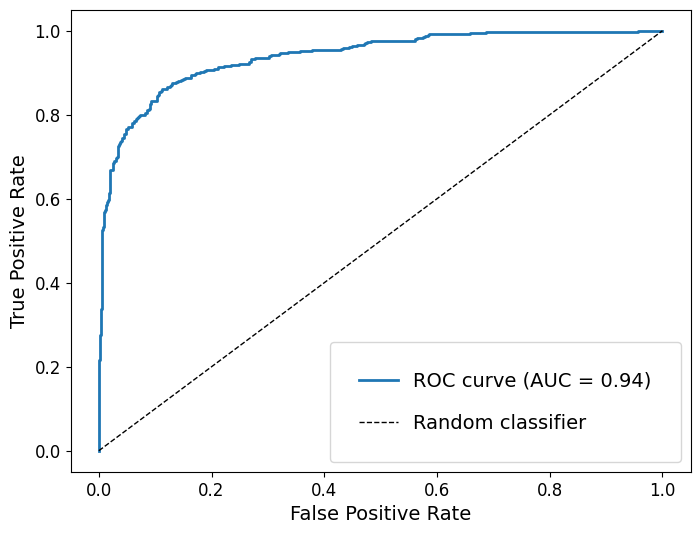

In [ ]:
# Predict probabilities for the positive class (class 1)
y_pred_prob = best_nb.predict_proba(X_test)[:, 1]  # Extract probabilities for class 1

# Compute ROC AUC score (binary classification)
roc_auc = roc_auc_score(y_test, y_pred_prob)  # No need for 'macro' here

# Print AUC
print(f"ROC AUC: {roc_auc:.4f}")

# Compute the ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob, pos_label=1)

# Plot the ROC curve
plt.figure(figsize=(8, 6))

# Plot the main ROC curve
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})', linewidth=2)

# Add diagonal line for a random classifier
plt.plot([0, 1], [0, 1], 'k--', label='Random classifier', linewidth=1)

# Customize axis labels with larger font size
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)

# Increase tick mark size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Customize legend (increase text size and spacing)
plt.legend(
    loc="lower right",
    fontsize=14,         # Increase font size
    borderpad=1.5,       # Increase padding inside legend box
    labelspacing=1.2,    # Increase spacing between legend items
    handlelength=2       # Increase line size in legend
)

# Save the ROC curve as a PDF
plt.savefig('ROC_Best_NB_Model.pdf')
plt.show()